**Table of contents**<a id='toc0_'></a>    
- [Example workflow in dockerHDDM](#toc1_)    
  - [Loading modules/packages](#toc1_1_)    
  - [Load the dataset](#toc1_2_)    
  - [Model specification and fitting](#toc1_3_)    
  - [Model diagnosis](#toc1_4_)    
    - [Diagnosis of Model 0](#toc1_4_1_)    
      - [Trace plot](#toc1_4_1_1_)    
      - [$\hat{R}$ and ESS](#toc1_4_1_2_)    
    - [DIC](#toc1_5_1_)    
    - [PSIS-LOO-CV](#toc1_5_2_)    
      - [ WAIC](#toc1_5_2_1_)    
      - [PSIS-LOO-CV](#toc1_5_2_2_)    
    - [PSIS issues](#toc1_5_3_)    
  - [Posterior predictive check](#toc1_6_)    
    - [Custom PPC plotting function](#toc1_6_1_)    
  - [Statistical Inference](#toc1_7_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Loading modules/packages](#toc0_)

In [1]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## <a id='toc1_2_'></a>[Load the dataset](#toc0_)

In [2]:
data_F = hddm.load_csv('./HDDM_InconStim_6Frame.csv')

In [3]:
data_F.head(10)

subj_idx  trial        rt  stim_frame key_response  response blockname   
0    114192      2  0.984893           6            e         1  BlockFvN  \
1    114192      6  0.926056           6            e         1  BlockFvN   
2    114192      9  0.854008           6            e         1  BlockFvN   
3    114192     11  0.881858           6            e         1  BlockFvN   
4    114192     12  0.918875           6            e         1  BlockFvN   
5    114192     13  0.906791           6            e         1  BlockFvN   
6    114192     15  0.949124           6            f         0  BlockFvN   
7    114192     16  0.839553           6            e         1  BlockFvN   
8    114192     17  1.006603           6            f         0  BlockFvN   
9    114192     24  0.855258           6            f         0  BlockFvN   

   task stim_file  HSF_emo  LSF_emo  congruence  
0     1         A        2        1           2  
1     1         B        1        2           2  
2     1         B        1        2           2  
3     1         B        1        2           2  
4     1         B        1        2           2  
5     1         B        1        2           2  
6     1         A        2        1           2  
7     1         A        2        1           2  
8     1         A        2        1           2  
9     1         A        2        1           2

In [4]:
data_F.tail(10)

subj_idx  trial        rt  stim_frame key_response  response blockname   
9740    993849    330  0.601870           6            n         0  BlockF_1  \
9741    993849    331  0.681040           6            b         1  BlockF_1   
9742    993849    332  0.599069           6            b         1  BlockF_1   
9743    993849    334  0.551520           6            n         0  BlockF_1   
9744    993849    336  0.538108           6            b         1  BlockF_1   
9745    993849    339  0.776732           6            b         1  BlockF_1   
9746    993849    341  0.503375           6            n         0  BlockF_1   
9747    993849    343  0.515187           6            n         0  BlockF_1   
9748    993849    344  0.614084           6            b         1  BlockF_1   
9749    993849    349  0.615294           6            b         1  BlockF_1   

      task stim_file  HSF_emo  LSF_emo  congruence  
9740     2         B        1        2           2  
9741     2         A        2        1           2  
9742     2         B        1        2           2  
9743     2         A        2        1           2  
9744     2         B        1        2           2  
9745     2         A        2        1           2  
9746     2         A        2        1           2  
9747     2         B        1        2           2  
9748     2         A        2        1           2  
9749     2         B        1        2           2

In [5]:
print("The number of trials: ", data_F.shape[0])
print("The number of variables: ", data_F.shape[1])
print("The number of participants: ", data_F.subj_idx.unique().shape[0])

The number of trials:  9750
The number of variables:  12
The number of participants:  65


## <a id='toc1_3_'></a>[Model specification and fitting](#toc0_)

We select the baseline model and two models with lowest DIC for demo purpose.

In [6]:
# Make a copy of the dataset for use in the models
df = data_F.copy()

# Model 5: Model with 'HSF_emo' as a predictor for 'v'
# In this model, we include 'z', 'v', 'a', and 't' and specify that 'v' is dependent on 'HSF_emo'
m5 = hddm.HDDM(df, include=['z', 'v', 'a', 't'], depends_on={'v': ['HSF_emo', 'task'], 'a': ['task']})

No model attribute --> setting up standard HDDM
Set model to ddm


Fitting model with new features (parallel sampling and return inferenceData, see [dockerHDDM Quick View](./dockerHDDM_Quick_View.ipynb) and **Section New features in dockerHDDM**). 

We set up 4 MCMC chains with 2500 samples with 1250 burn-ins with parallel fitting process and return inferred data for by the code `model.sample(5000, burn = 2500, return_infdata = True)`.

In [7]:
def run_sampling(
    m,
    n_samples=5000,
    n_burn=2500,
    n_chains=4,
    model_name="m",
    progress_bar=False,
):
    """
    Run Markov Chain Monte Carlo (MCMC) sampling for a given model and parameters.
    This function takes a model parameter `m` and runs MCMC sampling using PyMC2.3.8.
    It returns a arviz InferenceData object containing the posterior samples and post-fit model.
    Parameters
    ----------
    m : object
        The model parameter to be sampled.
    n_samples : int, optional
        The number of posterior samples to generate. Default is 10000.
    n_burn : int, optional
        The number of initial samples to discard. Default is 5000.
    n_chains : int, optional
        The number of MCMC chains to run in parallel. Default is 4.
    model_name : str, optional
        The name of the model to be used in the sampling process. Default is "m".
    progress_bar : boolean, optional
        Default=True. Set False hide sampling progress bar. 
    Returns
    -------
    InferenceData : arviz.InferenceData
        A trace object containing the posterior samples.
    Model: HDDM
        A post-fit HDDM model. 
    """

    m_infdata = m.sample(n_samples,
                         burn=n_burn,
                         chains=n_chains,
                         return_infdata=True,
                         save_name="model_fitted/" + model_name,
                         progress_bar=progress_bar)

    return m, m_infdata

**Note: Fitting six model with settings (10000 samples) takes about 8-9 hours on a PC with Intel® Core™ i7-10700 CPU @ 2.90GHz. Also, the memory of should be large enough, ~ 64 G memory is recommended. Otherwise,  recommend few samples (e.g., n_samples=2500, burn=1000).**

In [8]:
%time
m5, m5_infdata = run_sampling(m5, model_name="m5")

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 2.62 µs


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


hddm sampling elpased time:  362.723 s
Start converting to InferenceData...


## <a id='toc1_4_'></a>[Model diagnosis](#toc0_)

We use `az.plot_trace()` to visually check the trace plot of MCMC chains and use `az.summary()` to check $\hat{R}$ and Effective Sample Size (ESS). 

### <a id='toc1_4_1_'></a>[Diagnosis of Model 1](#toc0_)

#### <a id='toc1_4_1_1_'></a>[Trace plot](#toc0_)

We can also only plot selected parameters' traces. 
 
- use regex to select var_names that start with "a" and do not contain either "subj" or "std".

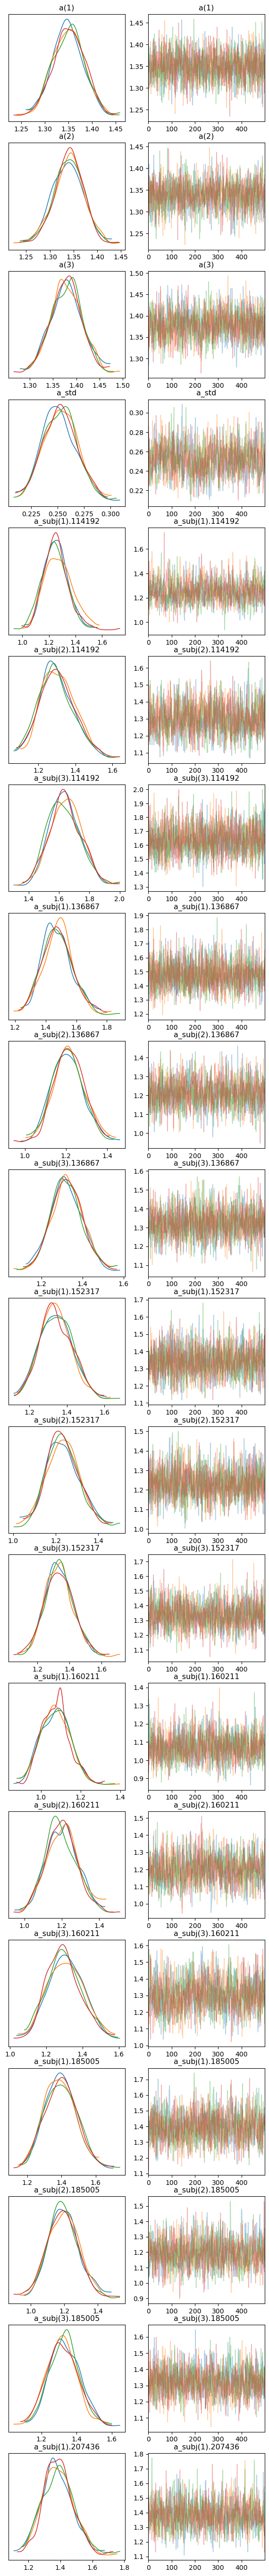

In [9]:
tmp_infdata = m5_infdata
plt.rc('font', size=16)

# plot traces for all parameters
axes = az.plot_trace(tmp_infdata, compact = False, figsize = [7, 70])

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


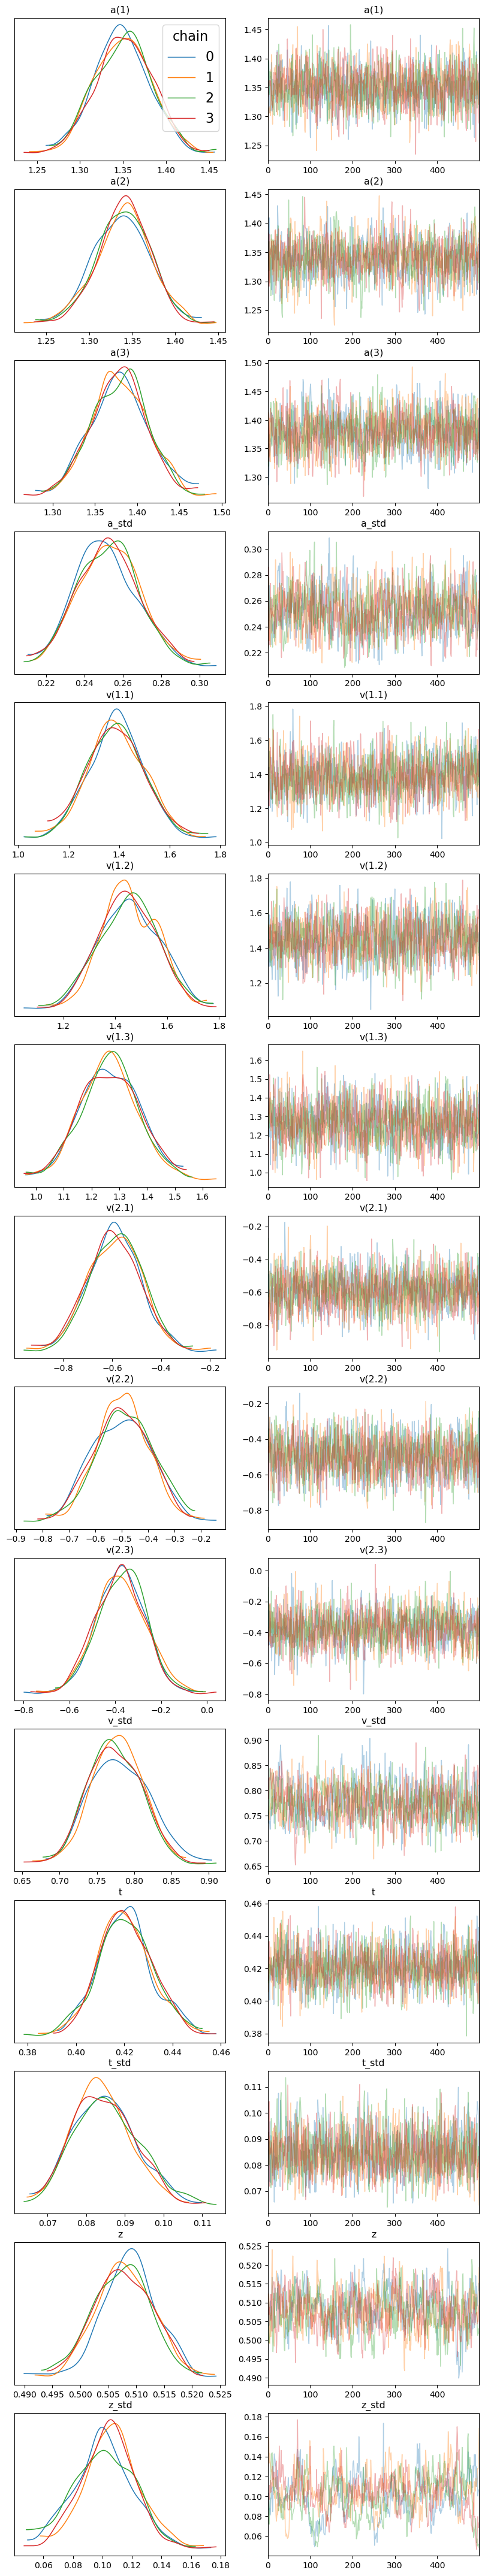

In [10]:
# select all population level parameters
axes = az.plot_trace(
    tmp_infdata,
    var_names=['~subj'],  # exclude individual level parameters
    filter_vars='regex',
    compact=False,
    legend=True,
    figsize=[10, 55]  # Adjusted figure size
)

#### <a id='toc1_4_1_2_'></a>[$\hat{R}$ and ESS](#toc0_)

In [11]:
summary_tmp = az.summary(tmp_infdata, kind = "diagnostics", round_to=4)
summary_tmp.sort_values('r_hat', ascending=False).head(10)

mcse_mean  mcse_sd   ess_bulk   ess_tail   r_hat
t_subj.900295        0.0050   0.0036   112.3396    20.2075  1.0564
a_subj(2).900295     0.0120   0.0089   113.2627   111.3296  1.0374
a_subj(1).900295     0.0145   0.0109   135.8626    52.3652  1.0362
t_subj.989829        0.0016   0.0011   221.0329   474.6905  1.0237
a_subj(1).989829     0.0075   0.0053   307.5445   428.4227  1.0147
z_std                0.0015   0.0011   175.2730   196.8733  1.0144
a_subj(2).944661     0.0063   0.0045   530.7224  1023.0764  1.0129
t_subj.944661        0.0009   0.0006   431.6633   741.6499  1.0126
t_subj.586339        0.0009   0.0006   533.0176   900.4443  1.0122
a_subj(1).328096     0.0023   0.0017  1638.6191  1467.7200  1.0114

#### <a id='toc1_4_3_3_'></a>[non-converge example](#toc0_)

Since some parameters have $\hat{R}$ > 1.01 and ESS bulk < 400, we double-check these two parameters with a trace plot.

- In terms of the posterior distribution, these parameters differ in the consistency of convergence of the four chains and their hdi (highest density interval).
- But should note whether the parameters obeys the truncate distribution, its mean and mode are clustered around 0.
- Whether it has non-converge feature in certain chains (the long regions of monotonicity like a line parallel to the x-axis).
    - (see 2.4 Diagnosing Numerical Inference in Martin, O.A., et. cl (2021) Bayseian Modeling and Computation in Python).

However, in general, the $\hat{R}$ of the two parameters is close to 1.01, and more broadly speaking, less than 1.1. And the distribution of the chains is still stable and consistent, we think this result is acceptable.

/opt/conda/lib/python3.9/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


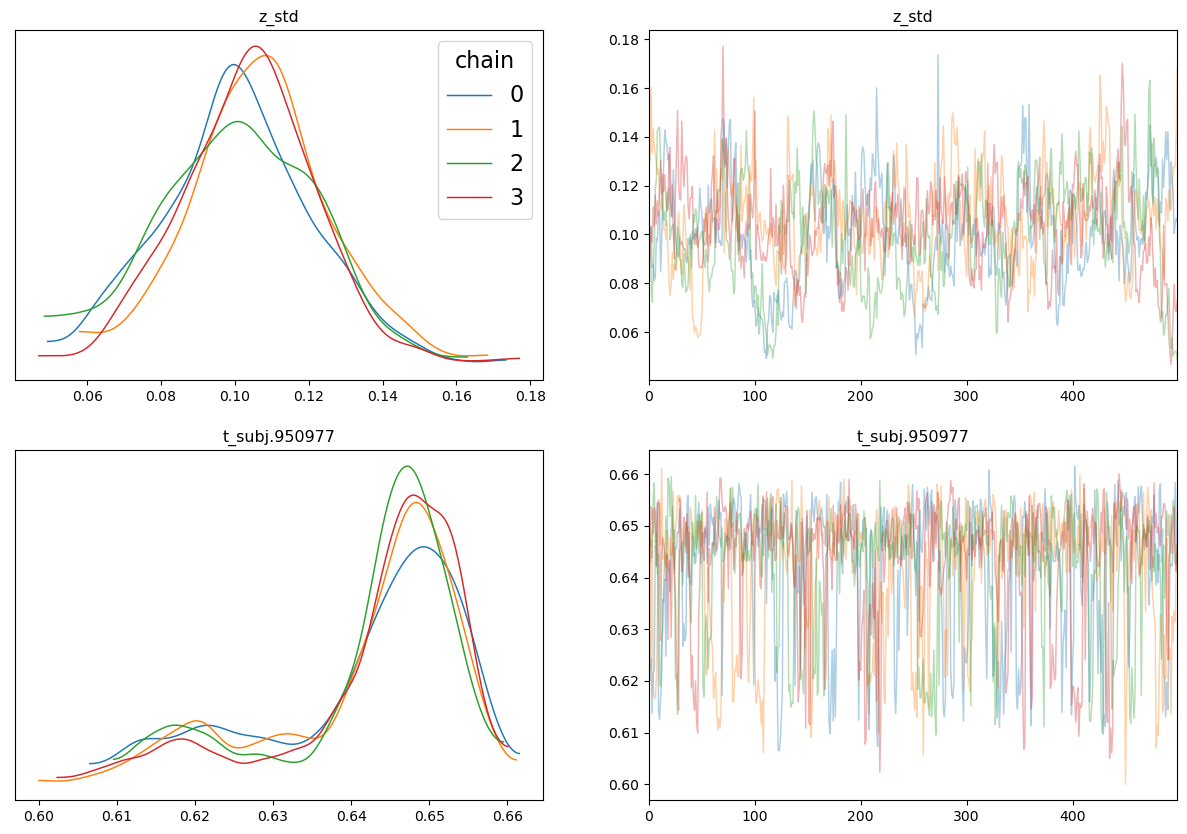

In [12]:
# select problematic parameter estimate
axes = az.plot_trace(
    m5_infdata, 
    var_names=['z_std', 't_subj.950977'], 
    compact = False, 
    legend=True, 
    figsize = [15, 10]
)

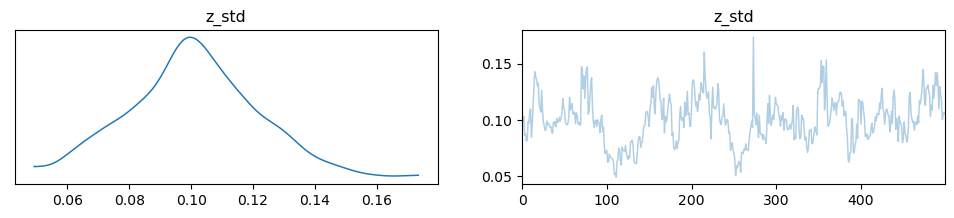

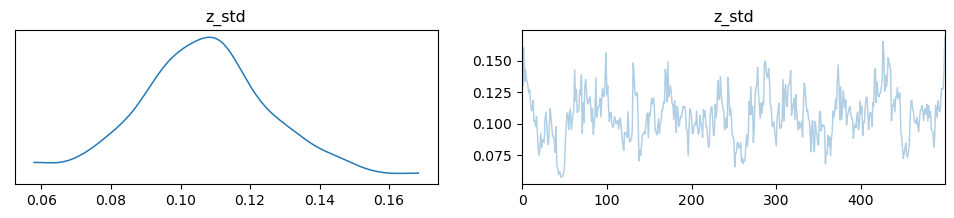

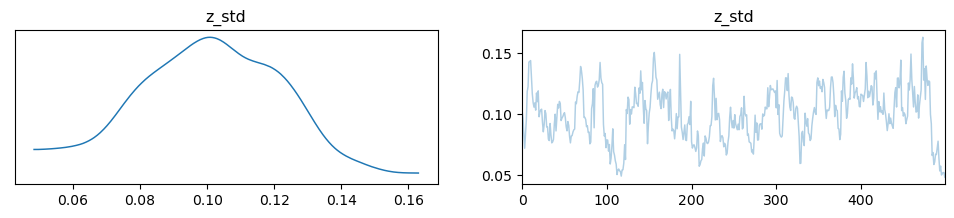

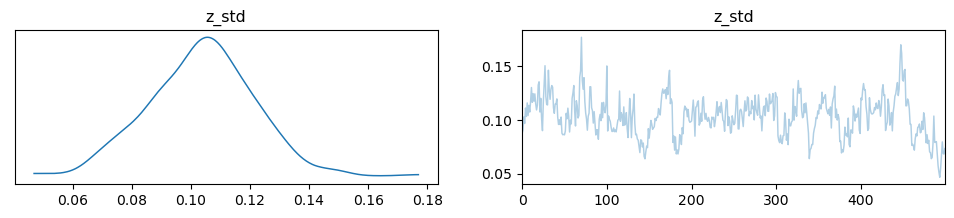

In [13]:
for i in range(4):
    
    az.plot_trace(
        m5_infdata, 
        var_names=['z_std'], 
        coords = {'chain': [i]}, 
        compact = False, 
        combined = False
    )

## <a id='toc1_5_'></a>[Model comparison and selection](#toc0_)

### <a id='toc1_5_1_'></a>[DIC](#toc0_)

Here we retrieve the DIC from each model in the models and sort by DIC.

In [14]:
dic_dict = {
  "m5":m5.dic,
}

comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic.sort_values(by=['DIC'], ascending = True)

model          DIC
m5    m5  9002.860276

### <a id='toc1_5_2_'></a>[PSIS-LOO-CV](#toc0_)

To evaluate models with criterions like WAIC and PSIS-LOO-CV, pointwise loglikelihoods are required (see Section Model Comparison in Manuscript). 

The following code shows how to calculate the pointwise loglikelihoods. 

**note**:
- **It can take half an hour or a few hours depending on CPU performance**.
- **If your RAM is less than or equal to 16g, an error may occur**. 

In [25]:
%time
m5_infdata = m5.to_infdata(loglike = True, save_name = "model_fitted/m5")

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 77 µs
Start converting to InferenceData...


#### <a id='toc1_5_2_1_'></a>[ WAIC](#toc0_)

In [16]:
# Compute WAIC for m0 only
waic_m5 = az.waic(m5_infdata, scale="deviance")
print(waic_m5)

Computed from 2000 posterior samples and 9750 observations log-likelihood matrix.

              Estimate       SE
deviance_waic 246489.99  39695.00
p_waic        119225.52        -

There has been a warning during the calculation. Please check the results.


In [17]:
# Assuming m0_infdta is your InferenceData object for m0
waic_m5 = az.waic(m5_infdata)
print(waic_m5)

Computed from 2000 posterior samples and 9750 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -123245.00  19847.50
p_waic    119225.52        -

There has been a warning during the calculation. Please check the results.


#### <a id='toc1_5_2_2_'></a>[PSIS-LOO-CV](#toc0_)

In [18]:
# Assuming m1_infdta is your InferenceData object for m1
loo_m5 = az.loo(m5_infdata, scale="deviance")
print(loo_m5)

/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k_post / b_post


Computed from 2000 posterior samples and 9750 observations log-likelihood matrix.

             Estimate       SE
deviance_loo      nan      nan
p_loo             nan        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9513   97.6%
 (0.5, 0.7]   (ok)         95    1.0%
   (0.7, 1]   (bad)        60    0.6%
   (1, Inf)   (very bad)   82    0.8%



### <a id='toc1_5_3_'></a>[PSIS issues](#toc0_)

**Warnings**: The above result shows that m0 is unable to compute PSIS-LOO-CV(elpd_loo), this is because of the overflow encountered in some calculation as the above warnings. 

As follow, we can check pareto_k $\hat{k}$. If $\hat{k} >  0.7$, which means importance sampling (PSIS) is not able to provide useful estimate for that component/observation. Highly influential observations have high $\hat{k}$ values. Very high $\hat{k}$ values often indicate model misspecification, outliers or mistakes in data processing.

Also, `p_loo`is large than *p*, which is number of parameters of the model. Large `p_loo` means the model is badly misspecified according to Aki Vehtari's [Q & A](https://avehtari.github.io/modelselection/CV-FAQ.html#18_What_is_the_interpretation_of_p_loo).Thus, `p_loo` is much larger than numbers of parameters for all models.

As we can see from below, this was primarily because of a few outliers. As HDDM allow for 5 percent of outliers in modelling, it is not surprising that these outliers stronly influenced the model performance. Here, we remove the outliers from all models and check the results again.

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 10.7 µs


/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k_post / b_post


<AxesSubplot: xlabel='Data Point', ylabel='Shape parameter k'>

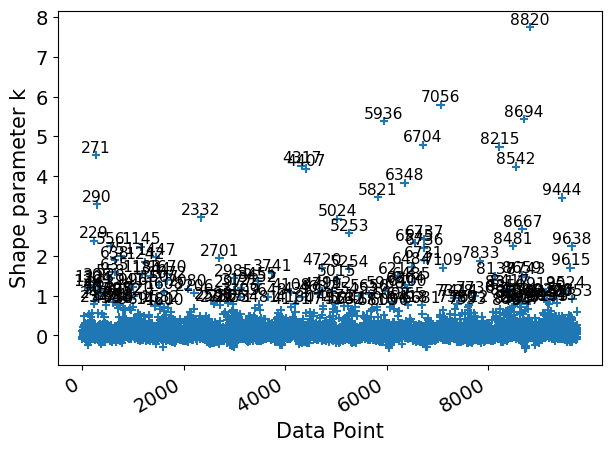

In [19]:
%time
khats = az.loo(m5_infdata, pointwise=True).pareto_k

az.plot_khat(khats, xlabels=True, threshold=0.7)

Here we used a very simple soluation: removing the outliers and re-calculate the `loo`.

In [20]:
%time
loo_m5 = az.loo(m5_infdata, pointwise=True)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k_post / b_post


In [21]:
# Identify outliers in m0
outliers5 = loo_m5.pareto_k.where(loo_m5.pareto_k >= 0.7, drop=True).obs_id.values

# Create an index array to remove the outliers from the data
new_indx_m5 = data_F.index.values[~np.isin(data_F.index.values, outliers5)]

# Optionally, filter the data without outliers
data_no_outliers = data_F.loc[new_indx_m5]

In [22]:
%time
m5_infdata = m5_infdata.isel(obs_id=new_indx_m5)

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.62 µs


In [23]:
loo_m5 = az.loo(m5_infdata, scale="deviance")
print(loo_m5)

/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1035: RuntimeWarning: invalid value encountered in multiply
  k_ary = np.log1p(-b_ary[:, None] * ary).mean(axis=1)  # pylint: disable=no-member
/opt/conda/lib/python3.9/site-packages/arviz/stats/stats.py:1052: RuntimeWarning: invalid value encountered in double_scalars
  sigma = -k_post / b_post


Computed from 2000 posterior samples and 9608 observations log-likelihood matrix.

             Estimate       SE
deviance_loo      nan      nan
p_loo             nan        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9513   99.0%
 (0.5, 0.7]   (ok)         95    1.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



- The nan (Not a Number) values in the deviance_loo and p_loo estimates typically indicate that something went wrong during the calculation of PSIS-LOO, which can occur due to issues like outliers, poor model fit, or issues in the likelihood matrix.

## <a id='toc1_6_'></a>[Posterior predictive check](#toc0_)

First, let's spend some time generating posterior predictions. Note that we set `n_ppc` is 50 means we generate 50 samples for each draws in each parameters. 

In [24]:
%time
m5_infdata = m5.to_infdata(loglike = True, ppc = True, n_ppc = 500, save_name = "model_fitted/m5")

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 2.38 µs
Start converting to InferenceData...
Start generating posterior prediction...
The time of generating PPC took 887.607 seconds


Then, we can plot the ppc by setting different coordinates. 

- Here we demonstrate plotting both the individual leve, `subj_idx` is 575285, 322944

In [32]:
# Assuming data_F is your DataFrame and 'subj_idx' is the column with sample IDs
random_samples = data_F['subj_idx'].sample(n=2, random_state=42)  # Adjust random_state for reproducibility
print(random_samples)

4534    575285
2516    322944
Name: subj_idx, dtype: int64


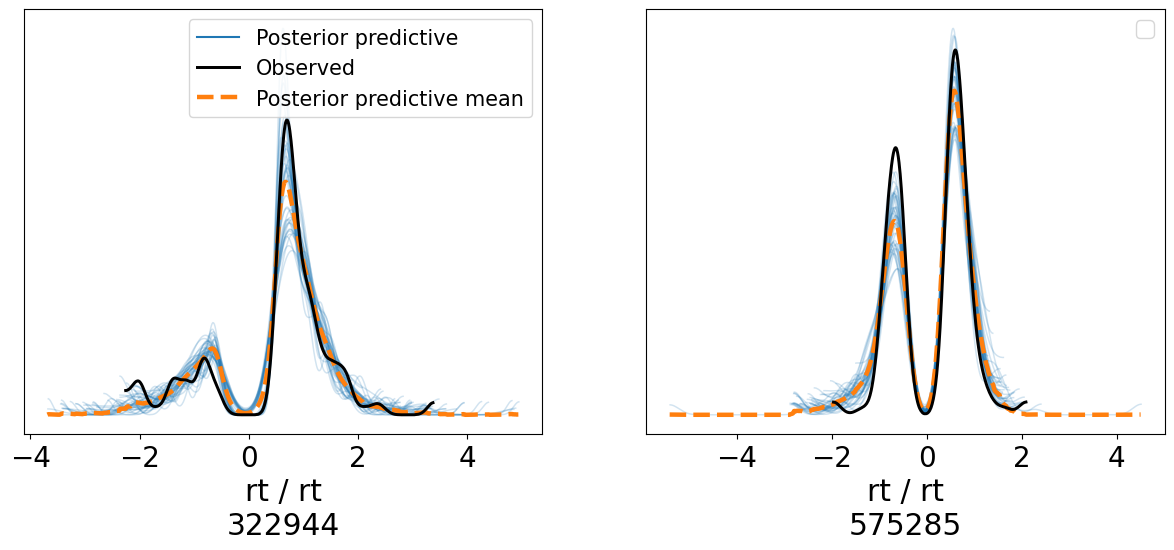

In [27]:
# reset coordinates
m5_infdata = m5_infdata.assign_coords(
  obs_id=m5_infdata.observed_data.coords['subj_idx'].values, 
  groups="observed_vars")

# plot ppc for subj_idx (obs_id) is 585285 and 322944
axes = az.plot_ppc(
    m5_infdata, 
    var_names= 'rt', 
    coords={'obs_id': [575285,322944]}, 
    num_pp_samples=100,
    random_seed = 2023, 
    flatten=[], 
    # legend=False,
    textsize=20, 
    alpha = 0.2
)

Then, let us plot ppc on different conditions. 

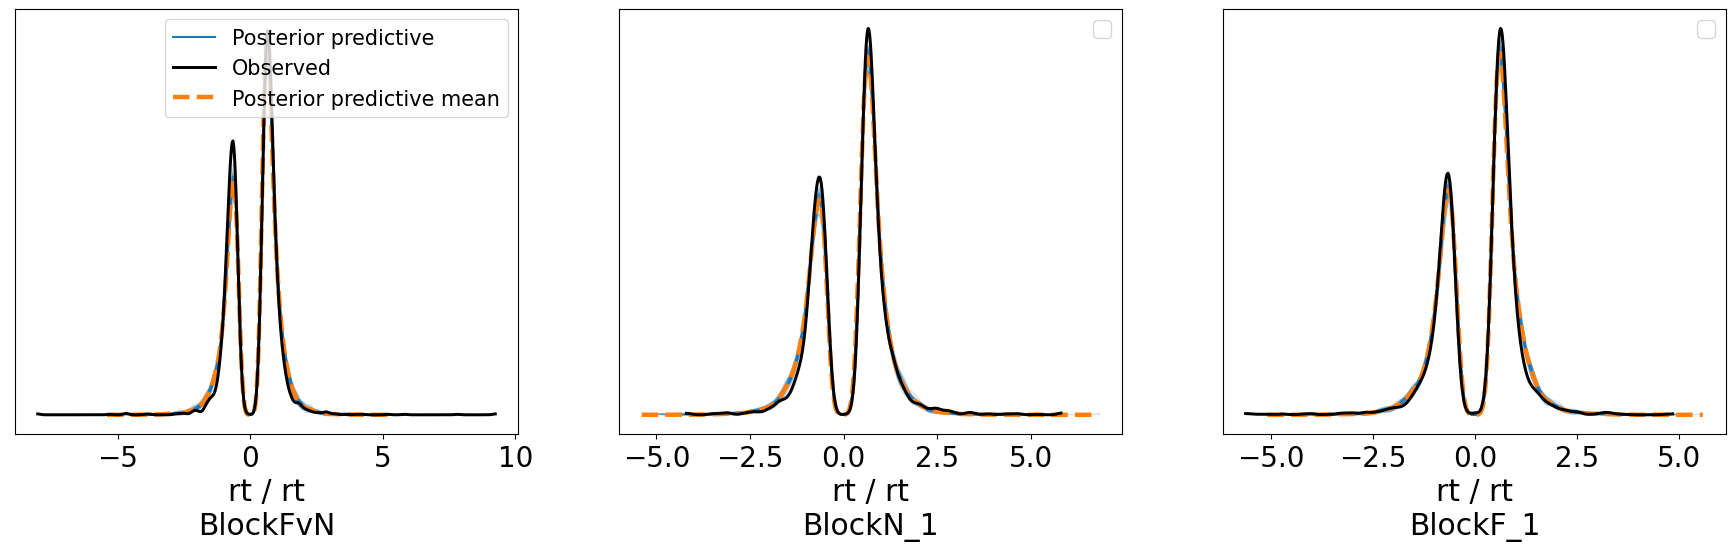

In [28]:
# Reset coordinates using 'blockname' instead of 'conf'
m5_infdata = m5_infdata.assign_coords(
    obs_id=m5_infdata.observed_data.variables['blockname'].values, 
    groups="observed_vars"
)

# Plot PPC for the three conditions in 'blockname'
axes = az.plot_ppc(
    m5_infdata, 
    var_names='rt', 
    coords={'obs_id': ["BlockFvN", "BlockF_1", "BlockN_1"]},  # Using your actual condition names
    num_pp_samples=100, 
    random_seed=2023, 
    flatten=[], 
    textsize=20, 
    alpha=0.2
)

### <a id='toc1_6_1_'></a>[Custom PPC plotting function](#toc0_)

To make it easier to plot ppc under different conditions, we define a function plot_ppc_by_cond, demonstrated as follows.

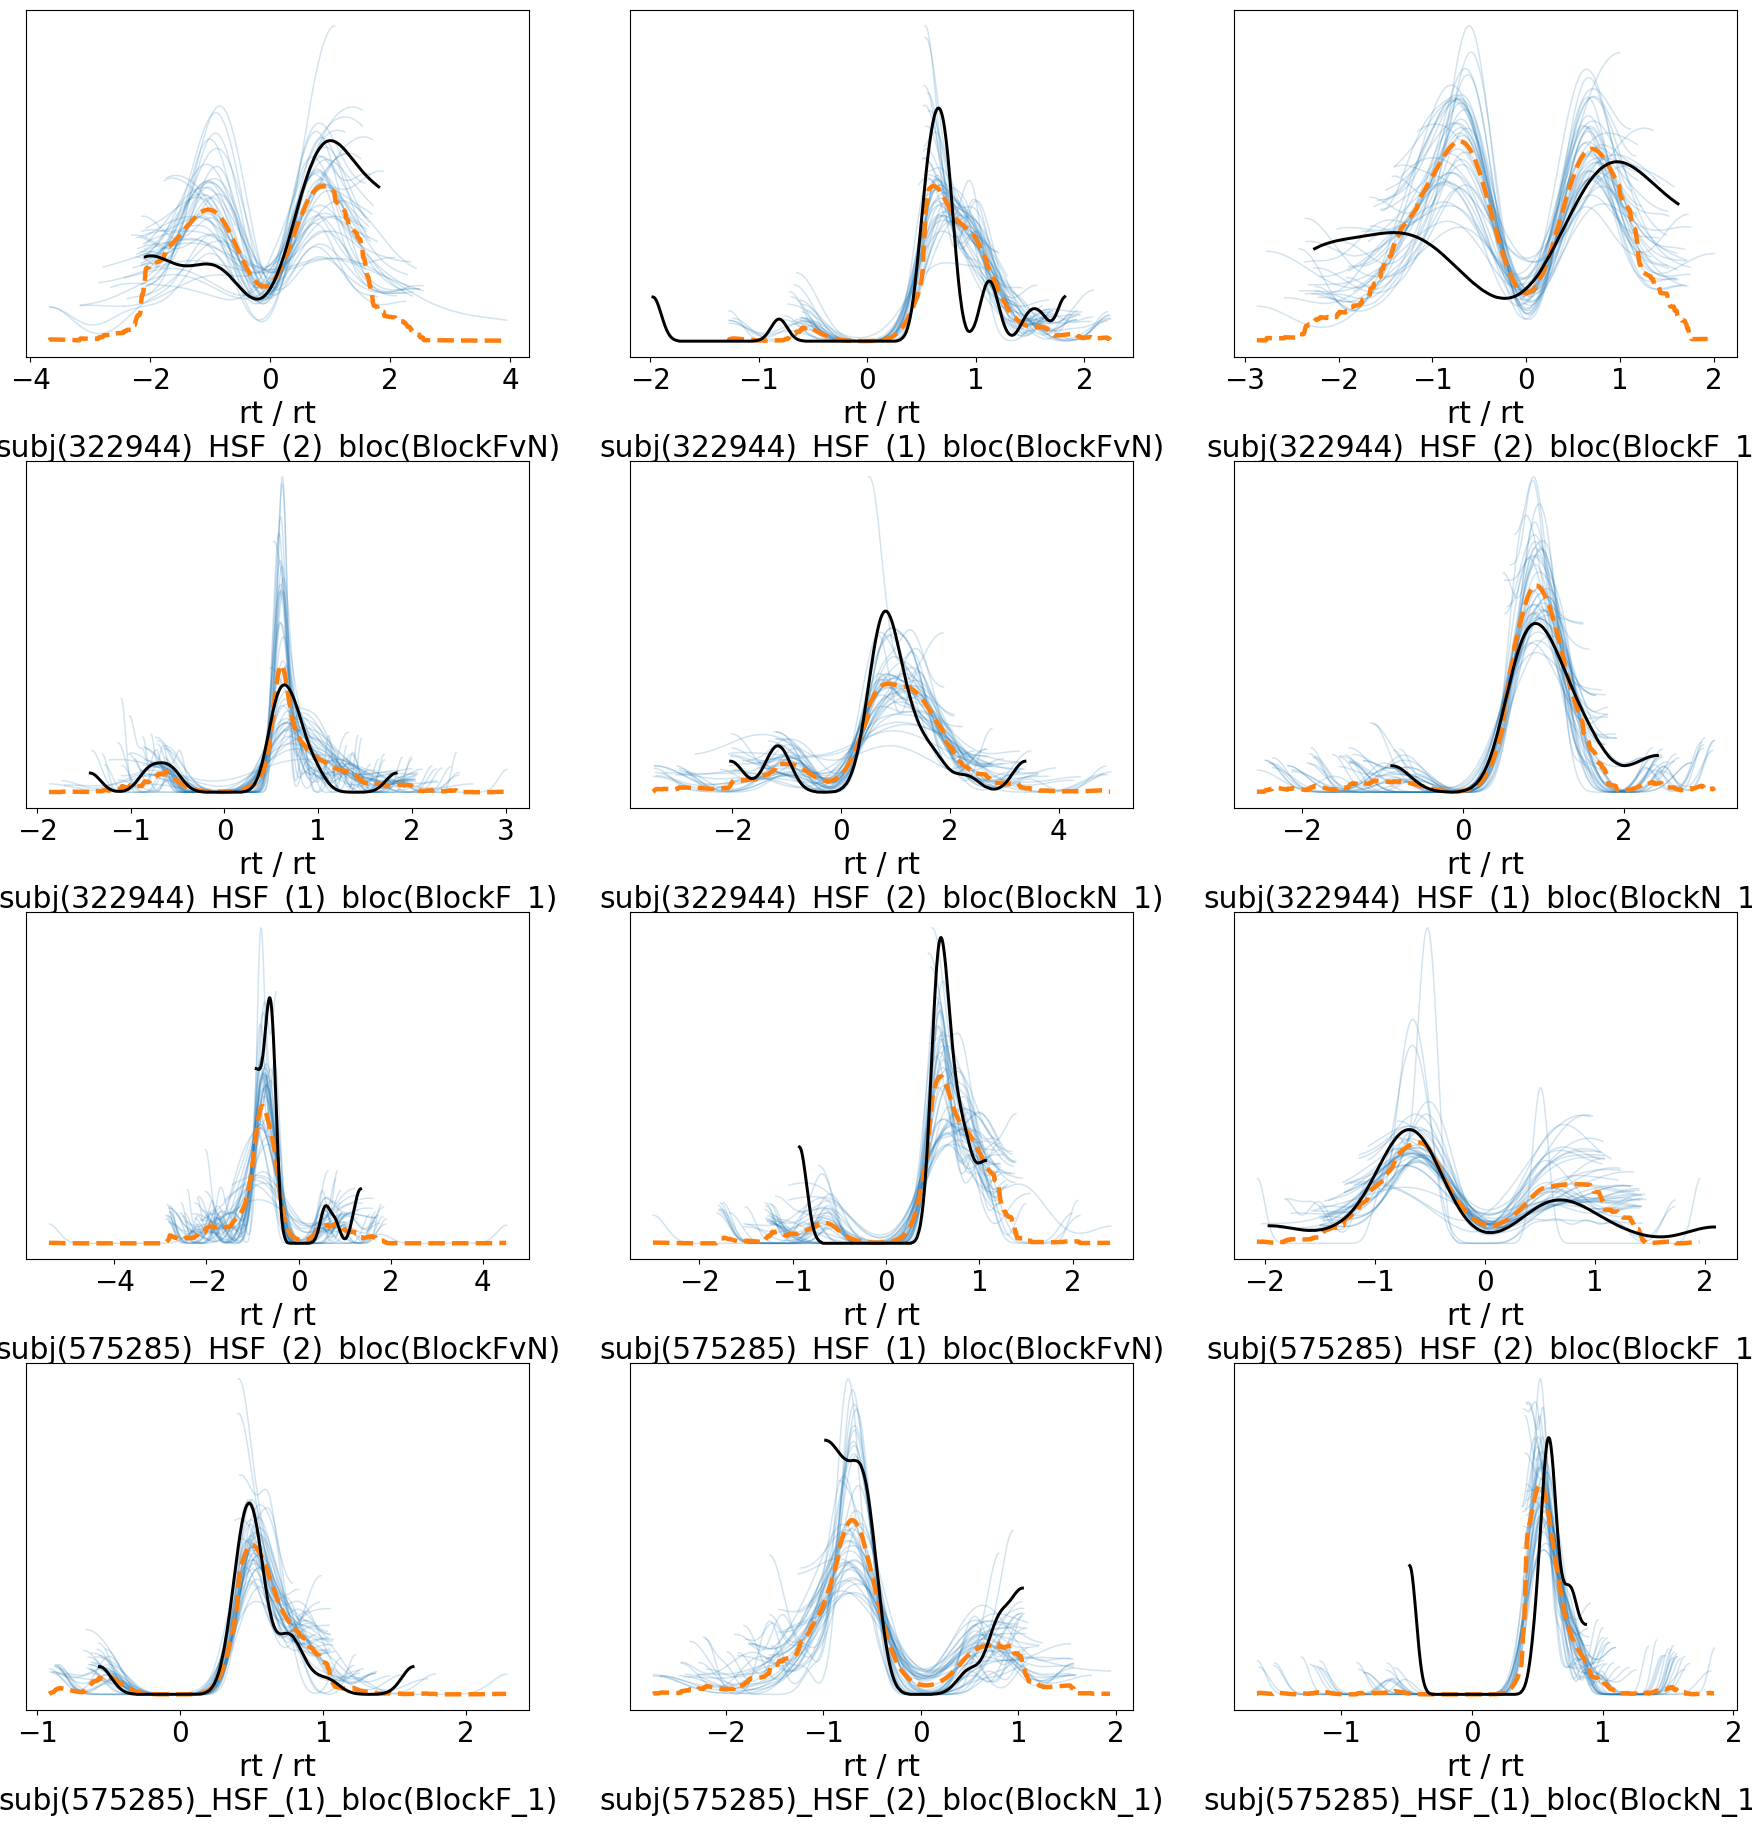

In [29]:
from kabuki.analyze import plot_ppc_by_cond

# more examples, by different condition and stimuli
condition_vars = ['HSF_emo','blockname']
subj_idx = [575285,322944]
plot_ppc_by_cond(m5_infdata,
                 subj_idx=subj_idx,
                 condition_vars=condition_vars,
                 num_pp_samples=100,
                 random_seed=2024,
                 legend=False,
                 textsize=20,
                 alpha=0.2)
# Increase line spacing to avoid xlabel being obscured
plt.subplots_adjust(hspace=0.3)
plt.show()

## <a id='toc1_7_'></a>[Statistical Inference](#toc0_)

Here we only examplified how to us ROPE + HDI method. 

- Assume that we are interested in the effect of spatial frequency and attention on drift rate `v` and we used [-0.2, 0.2] as the ROPE. 
- Then we can used visualize the ROPE and HDI with `az.plot_posterior()`.

## Drift Rate

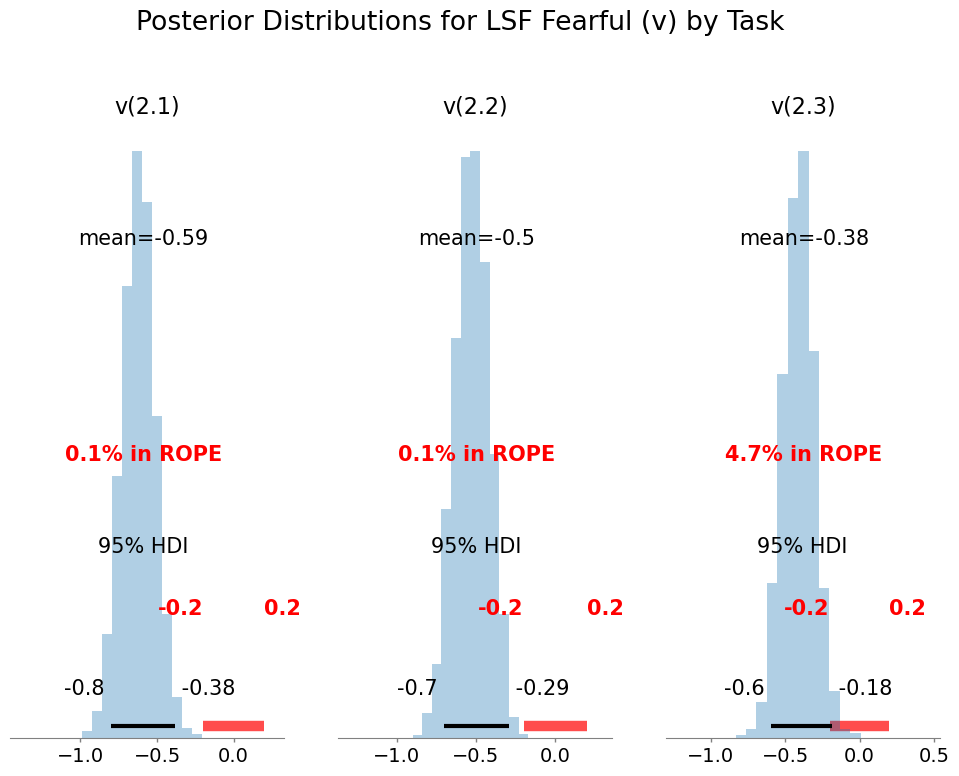

In [50]:
# Plot posteriors for LSF fearful (HSF_emo=2) across tasks
axes_v_lsf = az.plot_posterior(
    m5_infdata,
    var_names=["v(2.1)", "v(2.2)", "v(2.3)"],  # LSF fearful (HSF_emo=2) for tasks 1, 2, 3
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],  # ROPE for drift rate comparisons
    rope_color='r',
    figsize=(12, 8),
    textsize=14
)
plt.suptitle("Posterior Distributions for LSF Fearful (v) by Task", y=1.02);

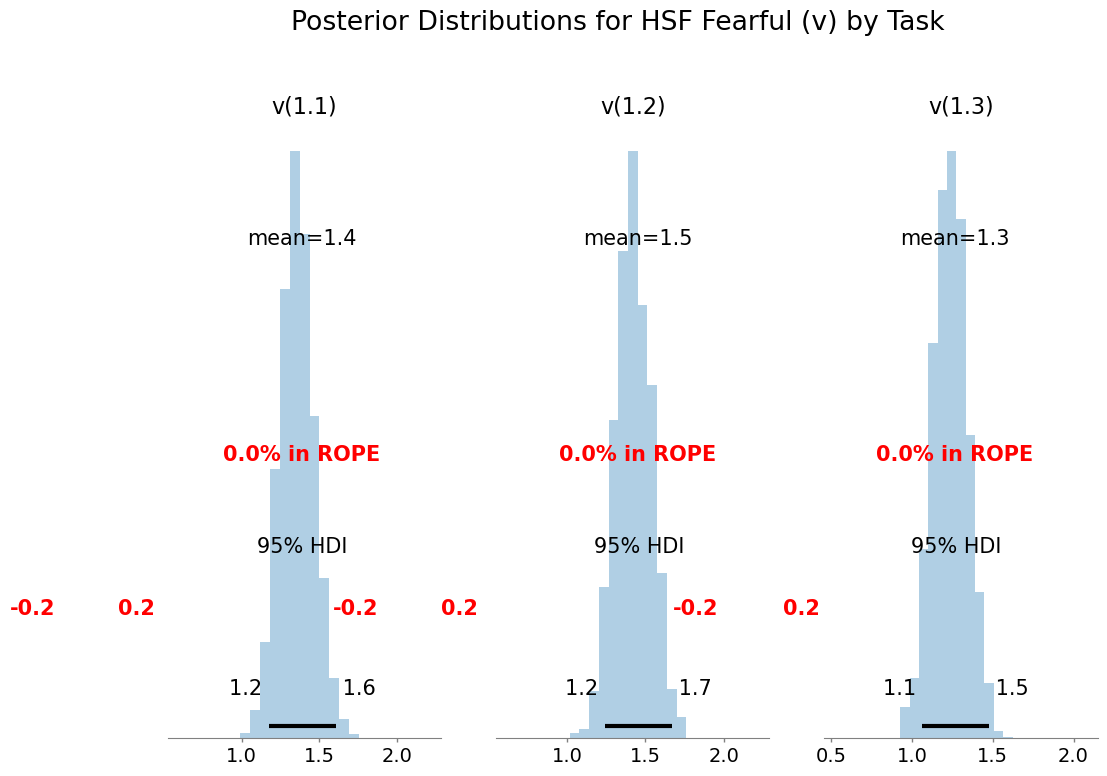

In [51]:
# Plot posteriors for HSF fearful (HSF_emo=1) across tasks
axes_v_hsf = az.plot_posterior(
    m5_infdata,
    var_names=["v(1.1)", "v(1.2)", "v(1.3)"],  # HSF fearful (HSF_emo=1) for tasks 1, 2, 3
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],  # ROPE for drift rate comparisons
    rope_color='r',
    figsize=(12, 8),
    textsize=14
)
plt.suptitle("Posterior Distributions for HSF Fearful (v) by Task", y=1.02);

In [ ]:
# Plot posteriors for HSF fearful (HSF_emo=1) across tasks
axes_v_hsf = az.plot_posterior(
    m5_infdata,
    var_names=["v(1.1)", "v(2.1)"],  # HSF fearful (HSF_emo=1) for tasks 1, 2, 3
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],  # ROPE for drift rate comparisons
    rope_color='r',
    figsize=(12, 8),
    textsize=14
)
plt.suptitle("Posterior Distributions across SF", y=1.02);

In [ ]:
# Plot posteriors for HSF fearful (HSF_emo=1) across tasks
axes_v_hsf = az.plot_posterior(
    m5_infdata,
    var_names=["v(1.2)", "v(2.2)"],  # HSF fearful (HSF_emo=1) for tasks 1, 2, 3
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],  # ROPE for drift rate comparisons
    rope_color='r',
    figsize=(12, 8),
    textsize=14
)
plt.suptitle("Posterior Distributions across SF", y=1.02);

In [ ]:
# Plot posteriors for HSF fearful (HSF_emo=1) across tasks
axes_v_hsf = az.plot_posterior(
    m5_infdata,
    var_names=["v(1.3)", "v(2.3)"],  # HSF fearful (HSF_emo=1) for tasks 1, 2, 3
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],  # ROPE for drift rate comparisons
    rope_color='r',
    figsize=(12, 8),
    textsize=14
)
plt.suptitle("Posterior Distributions across SF", y=1.02);

## Boundary Separation

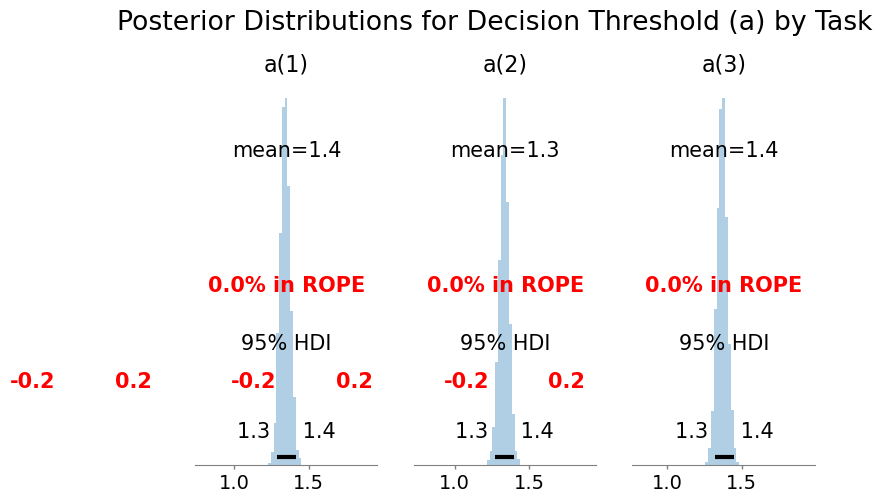

In [57]:
# Plot posteriors for threshold (a) across tasks
axes_a = az.plot_posterior(
    m5_infdata,
    var_names=["a(1)", "a(2)", "a(3)"],  # Thresholds for tasks 1, 2, 3
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],  # Adjust ROPE if needed (thresholds are typically positive)
    rope_color='r',
    figsize=(8, 5),
    textsize=14
)
plt.suptitle("Posterior Distributions for Decision Threshold (a) by Task", y=1.02);

## Hypothesis Testing

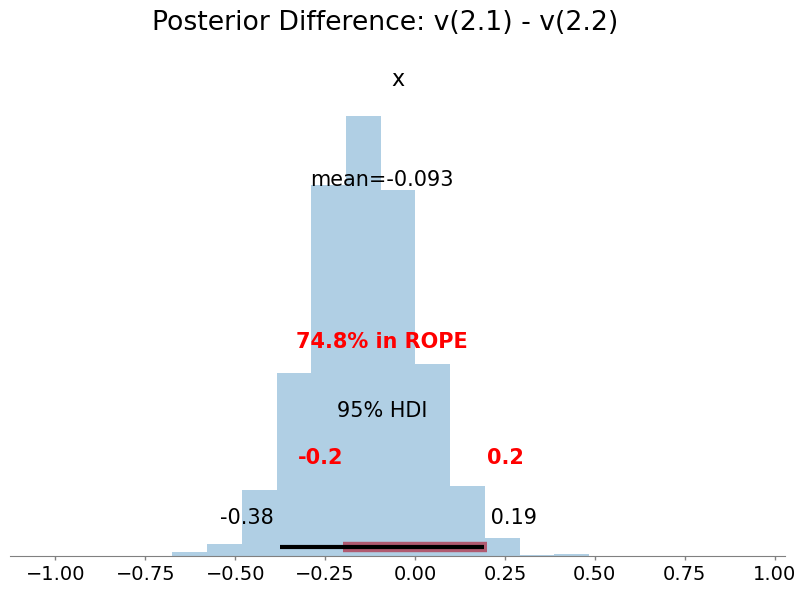

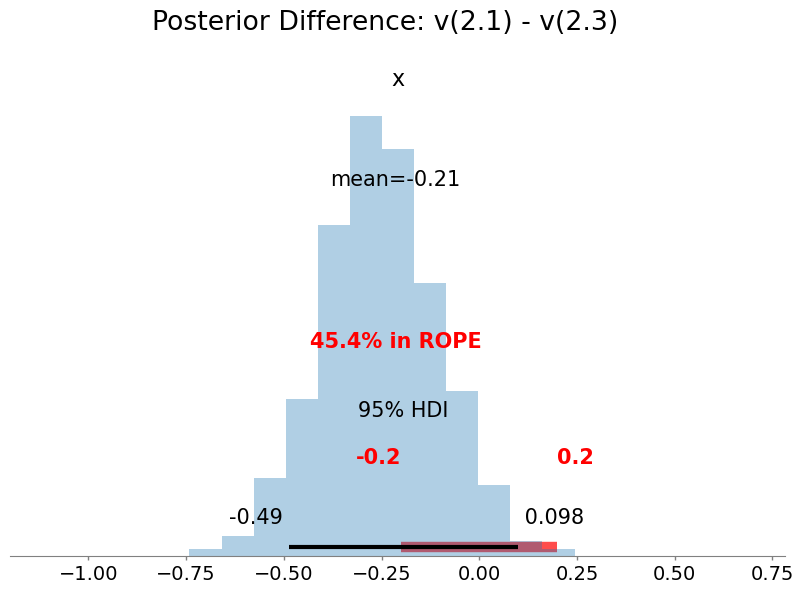

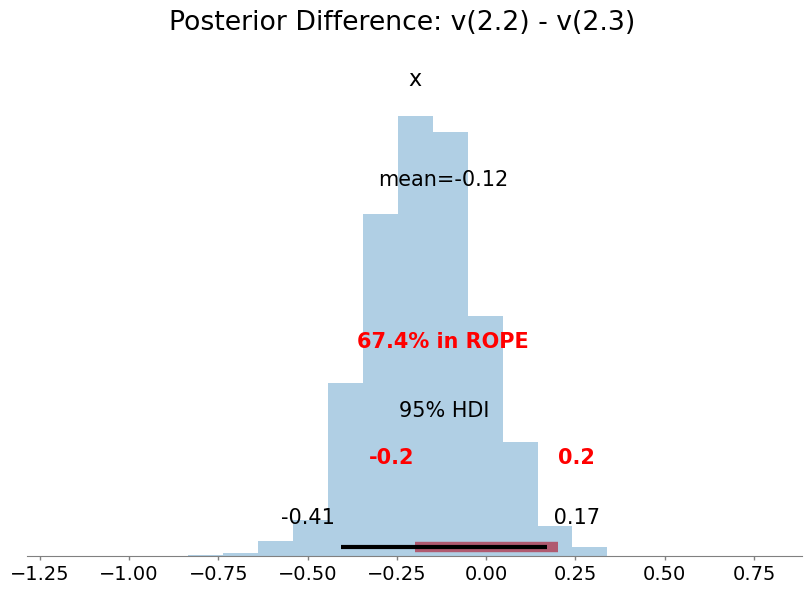

In [61]:
# Calculate posterior differences for LSF fearful (HSF_emo=2)
diff_v_2_1_vs_2_2 = m5_infdata.posterior["v(2.1)"] - m5_infdata.posterior["v(2.2)"]
diff_v_2_1_vs_2_3 = m5_infdata.posterior["v(2.1)"] - m5_infdata.posterior["v(2.3)"]
diff_v_2_2_vs_2_3 = m5_infdata.posterior["v(2.2)"] - m5_infdata.posterior["v(2.3)"]

# Plot posterior differences
az.plot_posterior(
    diff_v_2_1_vs_2_2,
    kind='hist',
    hdi_prob=0.95,
    rope=[0, 0.1],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(2.1) - v(2.2)", y=1.02);

az.plot_posterior(
    diff_v_2_1_vs_2_3,
    kind='hist',
    hdi_prob=0.95,
    rope=[0, 0.1],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(2.1) - v(2.3)", y=1.02);

az.plot_posterior(
    diff_v_2_2_vs_2_3,
    kind='hist',
    hdi_prob=0.95,
    rope=[0, 0.1],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(2.2) - v(2.3)", y=1.02);

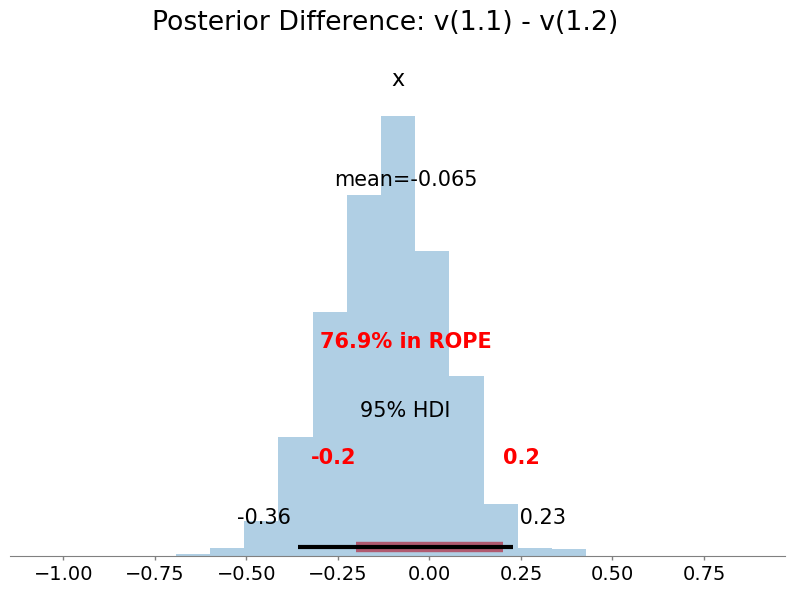

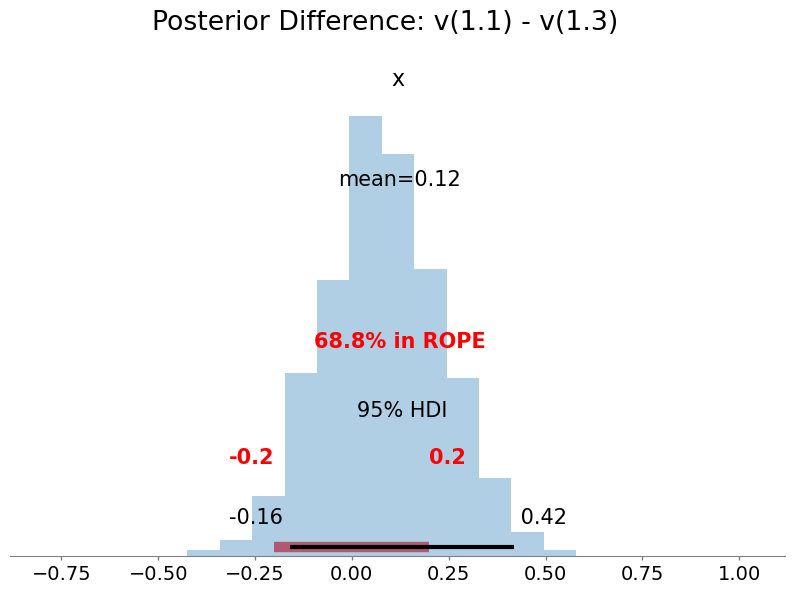

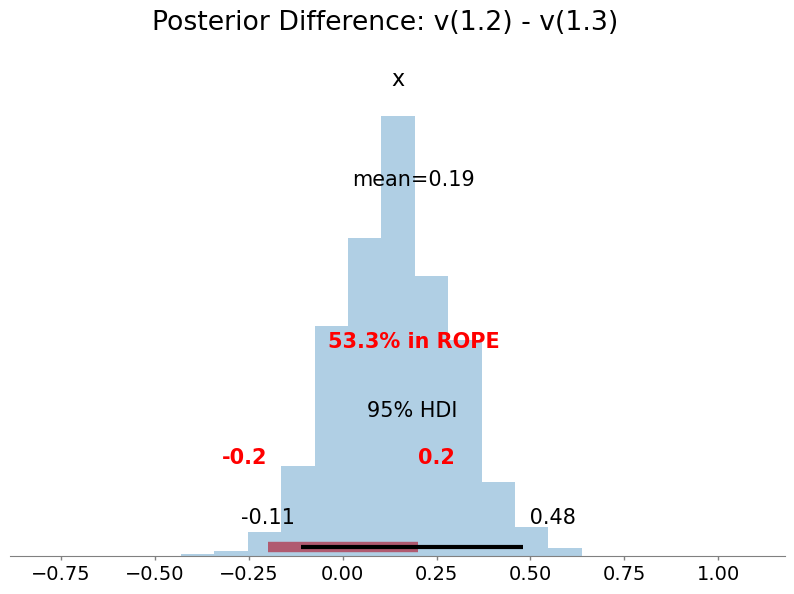

In [62]:
# Calculate posterior differences for HSF fearful (HSF_emo=1)
diff_v_1_1_vs_1_2 = m5_infdata.posterior["v(1.1)"] - m5_infdata.posterior["v(1.2)"]
diff_v_1_1_vs_1_3 = m5_infdata.posterior["v(1.1)"] - m5_infdata.posterior["v(1.3)"]
diff_v_1_2_vs_1_3 = m5_infdata.posterior["v(1.2)"] - m5_infdata.posterior["v(1.3)"]

# Plot posterior differences
az.plot_posterior(
    diff_v_1_1_vs_1_2,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(1.1) - v(1.2)", y=1.02);

az.plot_posterior(
    diff_v_1_1_vs_1_3,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(1.1) - v(1.3)", y=1.02);

az.plot_posterior(
    diff_v_1_2_vs_1_3,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(1.2) - v(1.3)", y=1.02);

In [ ]:
# Calculate posterior differences for HSF fearful (HSF_emo=1)
diff_v_1_1_vs_2_1 = m5_infdata.posterior["v(1.1)"] - m5_infdata.posterior["v(1.2)"]
diff_v_1_2_vs_2_2 = m5_infdata.posterior["v(1.2)"] - m5_infdata.posterior["v(2.2)"]
diff_v_1_3_vs_2_3 = m5_infdata.posterior["v(1.3)"] - m5_infdata.posterior["v(2.3)"]

# Plot posterior differences
az.plot_posterior(
    diff_v_1_1_vs_2_1,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(1.1) - v(2.1)", y=1.02);

az.plot_posterior(
    diff_v_1_2_vs_2_2,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(1.2) - v(2.2)", y=1.02);

az.plot_posterior(
    diff_v_1_3_vs_2_3,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: v(1.3) - v(2.3)", y=1.02);

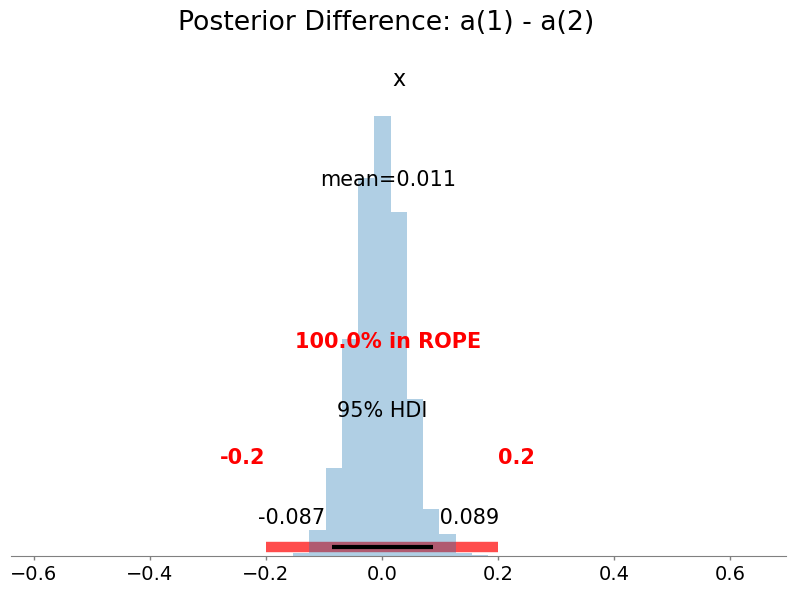

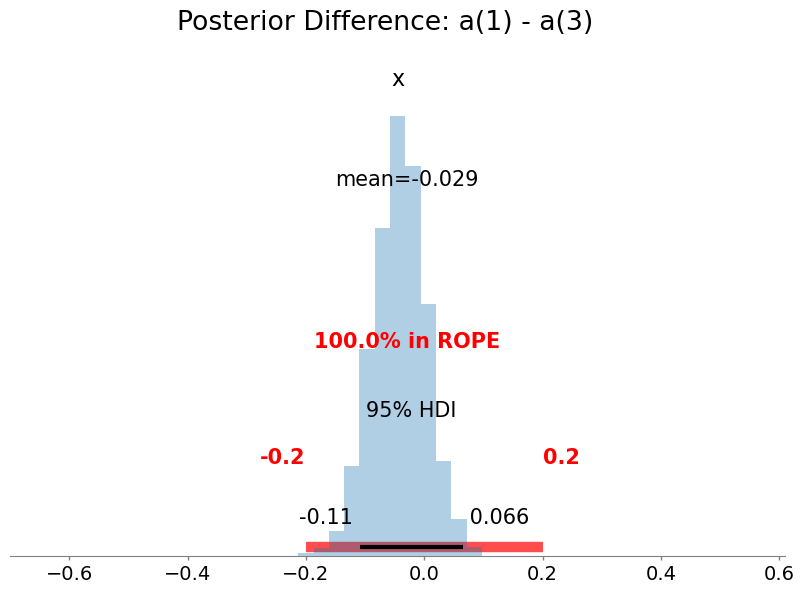

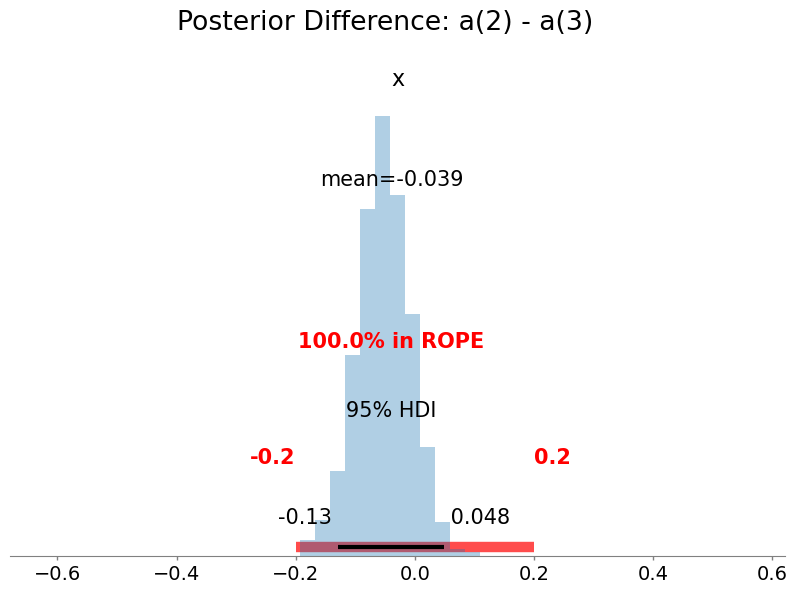

In [81]:
# Calculate posterior differences for a across tasks
diff_a_1_vs_2 = m5_infdata.posterior["a(1)"] - m5_infdata.posterior["a(2)"]
diff_a_1_vs_3 = m5_infdata.posterior["a(1)"] - m5_infdata.posterior["a(3)"]
diff_a_2_vs_3 = m5_infdata.posterior["a(2)"] - m5_infdata.posterior["a(3)"]

# Plot posterior differences
az.plot_posterior(
    diff_a_1_vs_2,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: a(1) - a(2)", y=1.02);

az.plot_posterior(
    diff_a_1_vs_3,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: a(1) - a(3)", y=1.02);

az.plot_posterior(
    diff_a_2_vs_3,
    kind='hist',
    hdi_prob=0.95,
    rope=[-0.2, 0.2],
    rope_color='r',
    figsize=(10, 6),
    textsize=14
)
plt.suptitle("Posterior Difference: a(2) - a(3)", y=1.02);

## Posterior Comparison

In [76]:
# Get the traces for drift rates v(2.1), v(2.2), and v(2.3) for LSF tasks
v_2_1 = m5["v(2.1)"]
v_2_2 = m5["v(2.2)"]
v_2_3 = m5["v(2.3)"]

# Perform and print posterior comparisons
print("P(v(2.1) > v(2.2)) = ", (v_2_1.trace() > v_2_2.trace()).mean())
print("P(v(2.1) > v(2.3)) = ", (v_2_1.trace() > v_2_3.trace()).mean())
print("P(v(2.2) > v(2.3)) = ", (v_2_2.trace() > v_2_3.trace()).mean())


P(v(2.1) > v(2.2)) =  0.27
P(v(2.1) > v(2.3)) =  0.0775
P(v(2.2) > v(2.3)) =  0.207


In [77]:
# Get the traces for drift rates v(1.1), v(1.2), and v(1.3) for HSF tasks
v_1_1 = m5["v(1.1)"]
v_1_2 = m5["v(1.2)"]
v_1_3 = m5["v(1.3)"]

# Perform and print posterior comparisons
print("P(v(1.1) > v(1.2)) = ", (v_1_1.trace() > v_1_2.trace()).mean())
print("P(v(1.1) > v(1.3)) = ", (v_1_1.trace() > v_1_3.trace()).mean())
print("P(v(1.2) > v(1.3)) = ", (v_1_2.trace() > v_1_3.trace()).mean())

P(v(1.1) > v(1.2)) =  0.329
P(v(1.1) > v(1.3)) =  0.7845
P(v(1.2) > v(1.3)) =  0.8885


In [ ]:
# Perform and print posterior comparisons for SF under same task

print("P(v(1.1) > v(2.1)) = ", (v_1_1.trace() > v_2_1.trace()).mean())
print("P(v(1.2) > v(2.2)) = ", (v_1_2.trace() > v_2_2.trace()).mean())
print("P(v(1.3) > v(2.3)) = ", (v_1_3.trace() > v_2_3.trace()).mean())

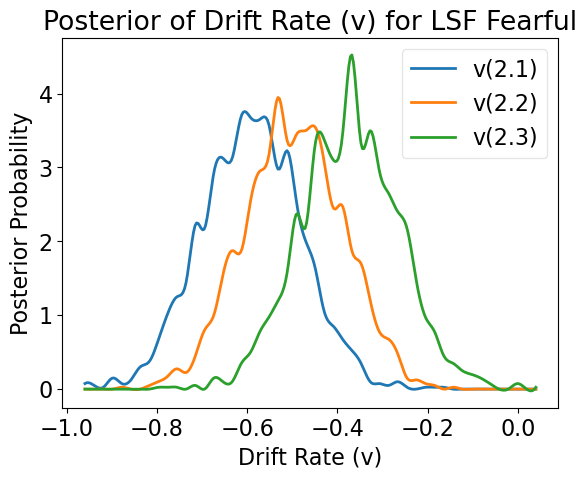

In [69]:
# Get the posterior nodes for drift rates v(2.1), v(2.2), and v(2.3) for LSF tasks 1, 2, 3
v_2_1, v_2_2, v_2_3 = m5.nodes_db.node[['v(2.1)', 'v(2.2)', 'v(2.3)']]

# Plot posterior distributions for LSF drift rates
hddm.analyze.plot_posterior_nodes([v_2_1, v_2_2, v_2_3])
plt.xlabel('Drift Rate (v)')
plt.ylabel('Posterior Probability')
plt.title('Posterior of Drift Rate (v) for LSF Fearful')
plt.savefig('./lsf_v_posterior.pdf', bbox_inches="tight")
plt.show()

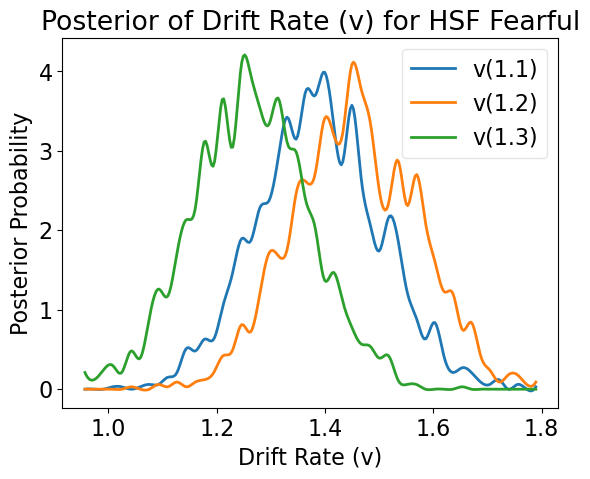

In [71]:
# Get the posterior nodes for drift rates v(1.1), v(1.2), and v(1.3) for HSF tasks 1, 2, 3
v_1_1, v_1_2, v_1_3 = m5.nodes_db.node[['v(1.1)', 'v(1.2)', 'v(1.3)']]

# Plot posterior distributions for HSF drift rates
hddm.analyze.plot_posterior_nodes([v_1_1, v_1_2, v_1_3])
plt.xlabel('Drift Rate (v)')
plt.ylabel('Posterior Probability')
plt.title('Posterior of Drift Rate (v) for HSF Fearful')
plt.savefig('./hsf_v_posterior.pdf', bbox_inches="tight")
plt.show()

In [ ]:
# Get the posterior nodes for drift rates v(1.1) and v(2.1)
v_1_1, v_2_1 = m5.nodes_db.node[['v(1.1)', 'v(2.1)']]

# Plot posterior distributions for LSF drift rates
hddm.analyze.plot_posterior_nodes([v_1_1, v_2_1])
plt.xlabel('Drift Rate (v)')
plt.ylabel('Posterior Probability')
plt.title('Posterior of Drift Rate v1.1 vs. v2.1')
plt.savefig('./lsf_v_posterior.pdf', bbox_inches="tight")
plt.show()

In [ ]:
# Get the posterior nodes for drift rates v(1.2) and v(2.2)
v_1_2, v_2_2 = m5.nodes_db.node[['v(1.2)', 'v(2.2)']]

# Plot posterior distributions for LSF drift rates
hddm.analyze.plot_posterior_nodes([v_1_2, v_2_2])
plt.xlabel('Drift Rate (v)')
plt.ylabel('Posterior Probability')
plt.title('Posterior of Drift Rate v1.2 vs. v2.2')
plt.savefig('./lsf_v_posterior.pdf', bbox_inches="tight")
plt.show()

In [ ]:
# Get the posterior nodes for drift rates v(1.3) and v(2.3)
v_1_3, v_2_3 = m5.nodes_db.node[['v(1.3)', 'v(2.3)']]

# Plot posterior distributions for LSF drift rates
hddm.analyze.plot_posterior_nodes([v_1_3, v_2_3])
plt.xlabel('Drift Rate (v)')
plt.ylabel('Posterior Probability')
plt.title('Posterior of Drift Rate v1.3 vs. v2.3')
plt.savefig('./lsf_v_posterior.pdf', bbox_inches="tight")
plt.show()

In [78]:
# Get the traces for decision thresholds a(1), a(2), and a(3)
a_1 = m5["a(1)"]
a_2 = m5["a(2)"]
a_3 = m5["a(3)"]

# Perform and print posterior comparisons
print("P(a(1) > a(2)) = ", (a_1.trace() > a_2.trace()).mean())
print("P(a(1) > a(3)) = ", (a_1.trace() > a_3.trace()).mean())
print("P(a(2) > a(3)) = ", (a_2.trace() > a_3.trace()).mean())


P(a(1) > a(2)) =  0.595
P(a(1) > a(3)) =  0.2565
P(a(2) > a(3)) =  0.1905


Similarly, violin plot can also be used:

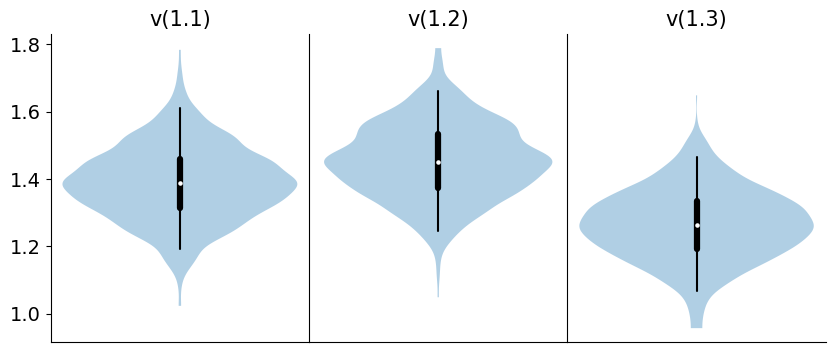

In [45]:
import seaborn as sns

# Plot posterior violin plot for multiple parameters (e.g., v, z, a)
axes = az.plot_violin(
    m5_infdata, 
    var_names=["v(1.1)","v(1.2)", "v(1.3)"],  # Include multiple parameters here
    figsize=(10, 4),
    textsize=14
)

sns.despine()  # Remove spines for cleaner visualization

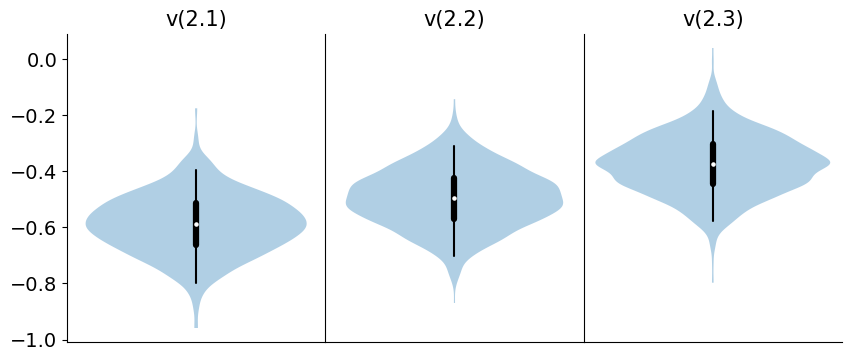

In [46]:
import seaborn as sns

# Plot posterior violin plot for multiple parameters (e.g., v, z, a)
axes = az.plot_violin(
    m5_infdata, 
    var_names=["v(2.1)","v(2.2)", "v(2.3)"],  # Include multiple parameters here
    figsize=(10, 4),
    textsize=14
)

sns.despine()  # Remove spines for cleaner visualization

In [ ]:
import seaborn as sns

# Plot posterior violin plot for multiple parameters (e.g., v, z, a)
axes = az.plot_violin(
    m5_infdata, 
    var_names=["v(1.1)","v(2.1)"],  # Include multiple parameters here
    figsize=(10, 4),
    textsize=14
)

sns.despine()  # Remove spines for cleaner visualization

In [ ]:
import seaborn as sns

# Plot posterior violin plot for multiple parameters (e.g., v, z, a)
axes = az.plot_violin(
    m5_infdata, 
    var_names=["v(1.2)","v(2.2)"],  # Include multiple parameters here
    figsize=(10, 4),
    textsize=14
)

sns.despine()  # Remove spines for cleaner visualization

In [ ]:
import seaborn as sns

# Plot posterior violin plot for multiple parameters (e.g., v, z, a)
axes = az.plot_violin(
    m5_infdata, 
    var_names=["v(1.3)","v(2.3)"],  # Include multiple parameters here
    figsize=(10, 4),
    textsize=14
)

sns.despine()  # Remove spines for cleaner visualization

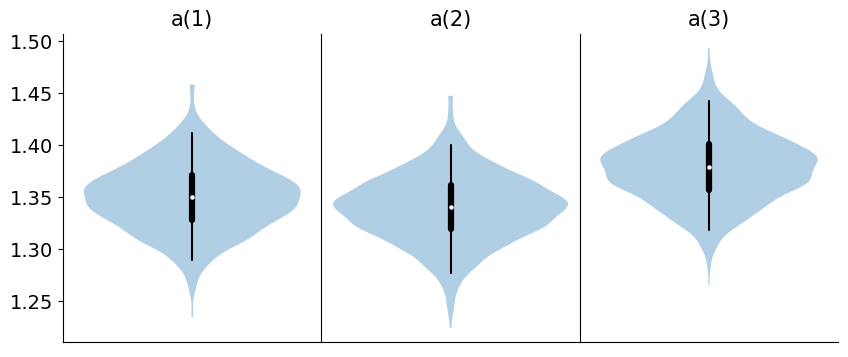

In [59]:
import seaborn as sns

# Plot posterior violin plot for multiple parameters (e.g., v, z, a)
axes = az.plot_violin(
    m5_infdata, 
    var_names=["a(1)","a(2)", "a(3)"],  # Include multiple parameters here
    figsize=(10, 4),
    textsize=14
)

sns.despine()  # Remove spines for cleaner visualization